In [1]:
#package imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import datasets
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

import re
from sklearn.decomposition import PCA
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
nltk.download('stopwords')
import plotly.graph_objs as plotly  # for interactive plots

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load data
training_data = pd.read_json("train.json")
test_data = pd.read_json("test.json")

stop_words = set(stopwords.words('english'))

In [3]:
stop_words = list(stop_words)

In [4]:
for word in ['i\'ve', 'i\'m', 'i\'ll', "i'm", "i've", "i'll", 'im',
            'pizza', 'request']:
    stop_words.append(word)

In [5]:
training_data.columns

Index(['giver_username_if_known',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request', 'r

In [6]:
# Look at fields used in the test data
test_data.columns

Index(['giver_username_if_known', 'request_id', 'request_text_edit_aware',
       'request_title', 'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc'],
      dtype='object')

In [5]:
# from Cornellia demo notebook
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

In [6]:
# modified from hw 9
def decode(token_ids):
    """Return a string with the decoded text given a list of token ids."""
    # Try looking up each id in the index, but return '#' (for OOV) if not found.

    key_list = list(token_index.keys())
    value_list = list(token_index.values())

    tokens = []

    for token_id in token_ids:
        if token_id == 0:
            tokens.append('#')
        else:
            position = value_list.index(token_id)
            tokens.append(key_list[position])

    # Connect the string tokens with a space.
    return ' '.join(tokens)


In [7]:
def create_token_index(requests):
    '''Creates a dictionary for token : token_id'''
    token_index = {'<START>':1,
              '#': 2,
              '<UNUSED>':3}
    count = 4

    for i in range(len(requests)):
        for j in requests[i].split():
            if j not in stop_words:
                if len(j) > 2:
                    if j not in token_index.keys():
                        token_index[j] = count
                        count += 1

    return token_index

In [8]:
def tokenize(requests):
    '''input list of text to output tokenized list'''
    token_requests = []

    for i in range(len(requests)):
        tokens = []
        for j in requests[i].split():
            if j in token_index:
                tokens.append(token_index[j])
            else:
                tokens.append(2)
        token_requests.append(tokens)

    return token_requests


In [9]:
# From HW 9
def pad_data(sequences, max_length):
  # Keras has a convenient utility for padding a sequence.
  # Also make sure we get a numpy array rather than an array of lists.
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences, maxlen=max_length, padding='post', value=0)))

In [10]:
# From HW 9
def limit_vocab(sequences, max_token_id, oov_id=2):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  reduced_sequences = np.copy(sequences)
  reduced_sequences[reduced_sequences >= max_token_id] = oov_id
  return reduced_sequences

In [11]:
training_data['request_text_edit_aware'] = training_data['request_text_edit_aware'].apply(preprocessor)

In [12]:
training_data['request_text_edit_aware']

0       hi i am in need of food for my 4 children we a...
1       i spent the last money i had on gas today im b...
2       my girlfriend decided it would be a good idea ...
3       it s cold i n hungry and to be completely hone...
4       hey guys i love this sub i think it s great ex...
                              ...                        
4035    is anyone out there kind enough to help me out...
4036    if someone could hook me up with a 15 gift car...
4037    have today off soo i ll be stuck in the house ...
4038    i ve never done anything like this before but ...
4039    like the title says had to pay an unexpected b...
Name: request_text_edit_aware, Length: 4040, dtype: object

In [13]:
Y = training_data['requester_received_pizza']

In [14]:
requests = training_data['request_text_edit_aware']

In [15]:
token_index = create_token_index(requests)

In [ ]:
len(token_index)

In [16]:
token_requests = tokenize(requests)

In [ ]:
len(token_requests[1])

In [ ]:
len(token_requests) == len(requests)

In [ ]:
# Verify things are working as intended
print(requests[10])
print(token_requests[10])
print(decode(token_requests[10]))

In [17]:
token_id_list = list(token_index.values())

In [19]:
def count_examples(token):
    '''Counts the number of positive and negative examples containing token'''
    pos_count = 0
    neg_count = 0

    # Loop through each request

    for i in range(len(token_requests)):

        if token in token_requests[i]:

            # Add to positive example count
            if Y[i] == True:
                pos_count += 1

            # Add to negative example count
            if Y[i] == False:
                neg_count += 1

    return (pos_count, neg_count)

In [ ]:
count_examples(500)

In [ ]:
pos_count = []
neg_count = []

for token_id in token_id_list:
    pos,neg = count_examples(token_id)
    pos_count.append(pos)
    neg_count.append(neg)

In [ ]:
d = {
    'word': token_id_list,
    'n_pos': pos_count,
    'n_neg': neg_count
}

In [ ]:
words_df = pd.DataFrame(d)

In [ ]:
clean_df = words_df[words_df.n_pos > 50]
clean_df = clean_df[words_df.n_neg > 50]

In [ ]:
clean_df.sort_values('n_pos', ascending = False)[25:50]

In [ ]:
decode([49])

In [18]:
padded_token_requests = pad_data(token_requests, 100)

In [19]:
reduced_token_requests = limit_vocab(padded_token_requests, max_token_id=5000)

In [20]:
reduced_one_hot = tf.keras.utils.to_categorical(reduced_token_requests)

In [ ]:
len(reduced_one_hot)

In [21]:
X_train = reduced_one_hot[:3636]
Y_train = Y[:3636]
X_test = reduced_one_hot[3636:]
Y_test = Y[3636:]

In [22]:
X_train.shape

(3636, 100, 5000)

In [23]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [24]:
def build_onehot_model3(average_over_positions=False):
  """Build a tf.keras model for one-hot data."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation="sigmoid"         # sigmoid activation for classification
  ))

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=.01),
                metrics=[tf.keras.metrics.BinaryAccuracy()])

  return model

In [25]:
model5 = build_onehot_model3(average_over_positions=False)

Epoch 1/15
52/52 [==============================] - 9s 148ms/step - loss: 0.5703 - binary_accuracy: 0.7466 - val_loss: 0.5369 - val_binary_accuracy: 0.7665
Epoch 2/15
52/52 [==============================] - 7s 142ms/step - loss: 0.2355 - binary_accuracy: 0.9361 - val_loss: 0.5476 - val_binary_accuracy: 0.7637
Epoch 3/15
52/52 [==============================] - 6s 119ms/step - loss: 0.1495 - binary_accuracy: 0.9661 - val_loss: 0.5682 - val_binary_accuracy: 0.7637
Epoch 4/15
52/52 [==============================] - 7s 134ms/step - loss: 0.1073 - binary_accuracy: 0.9798 - val_loss: 0.5776 - val_binary_accuracy: 0.7637
Epoch 5/15
52/52 [==============================] - 6s 117ms/step - loss: 0.0840 - binary_accuracy: 0.9838 - val_loss: 0.5944 - val_binary_accuracy: 0.7527
Epoch 6/15
52/52 [==============================] - 11s 210ms/step - loss: 0.0701 - binary_accuracy: 0.9884 - val_loss: 0.6008 - val_binary_accuracy: 0.7665
Epoch 7/15
52/52 [==============================] - 10s 197ms/s

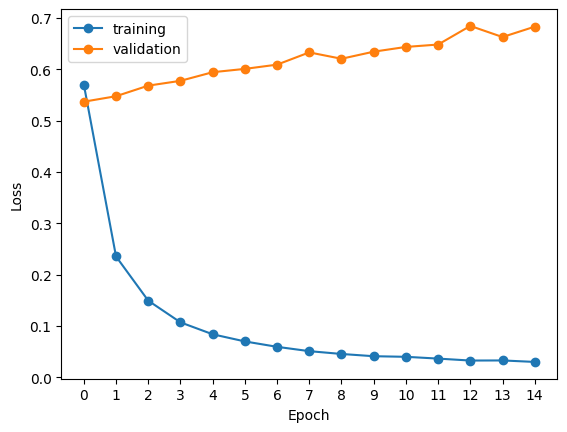

In [26]:
history5 = model5.fit(
  x = X_train,  # one-hot training data
  y = Y_train,          # corresponding binary labels
  epochs=15,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history5 = pd.DataFrame(history5.history)
plot_history(history5)

In [1]:
probabilities = model5.predict(X_train)
threshold = 0.5
binary_predictions = (probabilities > threshold).astype(int)
confusion_matrix(Y_train, binary_predictions)

NameError: ignored

In [ ]:
#print ('Accuracy:', forest.score(vocab_train, train_labels))

In [ ]:
# Store the columns that are usable for the predictions
test_features = list(test_data.columns)

X = training_data[training_data.columns[training_data.columns.isin(test_features)]]
Y = training_data['requester_received_pizza']

train_data, train_labels = X[:3609], Y[:3609]
val_data, val_labels = X[3609:], Y[3609:]

In [27]:
test_data['request_text_edit_aware'] = test_data['request_text_edit_aware'].apply(preprocessor)

In [28]:
test_requests = test_data['request_text_edit_aware']

In [30]:
token_index = create_token_index(test_requests)

In [31]:
test_token_requests = tokenize(requests)

In [32]:
test_padded_token_requests = pad_data(test_token_requests, 100)

In [34]:
test_reduced_token_requests = limit_vocab(test_padded_token_requests, max_token_id=5000)

In [35]:
test_reduced_one_hot = tf.keras.utils.to_categorical(test_reduced_token_requests)

In [36]:
test_reduced_one_hot.shape

(4040, 100, 5000)

In [37]:
Y2 = training_data['requester_received_pizza']

In [38]:
X_test = test_reduced_one_hot[:3636]
Y_test = Y2[:3636]

In [39]:
X_test.shape

(3636, 100, 5000)

In [3]:
predictions = model5.predict(X_test)

NameError: ignored

In [4]:
# function to create dataframe
def get_submission_csv(predictions):
    test_ids = test_data['request_id']

    d = {'request_id': test_ids,
    'requester_received_pizza': predictions}

    df = pd.DataFrame(data=d)
    df['requester_received_pizza'] = df['requester_received_pizza'].astype(int)

    return df

In [5]:
# flatten predictions
predictions_flat = predictions.flatten()

# create dataframe using function
predictions_df = get_submission_csv(predictions_flat)

# create csv from dataframe
df_all_posts.to_csv('one_hot_model_predictions.csv', index=False)

NameError: ignored